# Preprocessing Second Batch of Songs

In [3]:
from functools import reduce
from glob import glob
import json
from multiprocessing import cpu_count
import pickle
import os
import re

from deepmerge import always_merger

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from spotipy import Spotify
from spotipy.oauth2 import SpotifyClientCredentials

## Table of Contents

1. Loading in Tables


## 1. Loading in Tables

In [7]:
# all songs I attempted to pull
# with open('../data/new_tracks_20190103.json', 'r') as f:
#     new_tracks = json.load(f)


# matched_songs = pd.read_csv('../data/matched_songs_20190209.csv', index_col = 0)
main_wfeats = pd.read_csv('../data/main_wfeats.csv', index_col = 0)
genres = pd.read_csv('../data/genres.csv', index_col = 0)
gs_lookup = pd.read_csv('../data/gsong_lookup.csv', index_col=0)

In [3]:
main_wfeats.columns

Index(['song_id', 'album_release_date', 'artist_id', 'artist_name',
       'duration_ms', 'explicit', 'linked_album', 'song_title', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'key_changes', 'mean_song_conf', 'mean_loudness', 'mean_mode',
       'mean_mode_conf', 'mean_tempo', 'mean_tempo_conf', 'var_song_conf',
       'var_loudness', 'var_mode', 'var_mode_conf', 'var_tempo',
       'var_tempo_conf', 'tm_dim_1', 'tm_dim_2', 'tm_dim_3', 'tm_dim_4',
       'tm_dim_5', 'tm_dim_6', 'tm_dim_7', 'tm_dim_8', 'tm_dim_9', 'tm_dim_10',
       'tm_dim_11', 'tm_dim_12', 'tv_dim_1', 'tv_dim_2', 'tv_dim_3',
       'tv_dim_4', 'tv_dim_5', 'tv_dim_6', 'tv_dim_7', 'tv_dim_8', 'tv_dim_9',
       'tv_dim_10', 'tv_dim_11', 'tv_dim_12', 'pm_dim_1', 'pm_dim_2',
       'pm_dim_3', 'pm_dim_4', 'pm_dim_5', 'pm_dim_6', 'pm_dim_7', 'pm_dim_8',
       'pm_dim_9', 'pm_dim_10', 'pm_dim_

In [4]:
artists = pd.read_csv('../data/artist_list_v2.csv', index_col=0)

### 1a. Grabbing Mean & Variance Segment Values

In [5]:
def combine_section_mean_var(fp):
    '''
    Given a file path, grabs mean and variance segment dictionaries
    and combines them together
    '''
    directory = {
        'means' : [],
        'vars' : [],
    }
    
    # grabbing all files
    for file in os.listdir(fp):
        if 'section_mean_' in file:
            directory['means'].append(file)
        elif 'section_var_' in file:
            directory['vars'].append(file)
    
    # base files
    with open(f"{fp}/{directory['means'][0]}", 'r') as f:
        mean_dict = json.load(f)
    with open(f"{fp}/{directory['vars'][0]}", 'r') as f:
        vars_dict = json.load(f)
    
    # adding addtl files
    for i in range(1, len(directory['means'])):
        with open(f"{fp}/{directory['means'][i]}", 'r') as f:
            addition = json.load(f)
        mean_dict.extend(addition)
                  
    for i in range(1, len(directory['vars'])):
        with open(f"{fp}/{directory['vars'][i]}", 'r') as f:
            addition = json.load(f)
        vars_dict.extend(addition)
    
    return mean_dict, vars_dict

In [6]:
means, variances = combine_section_mean_var('../data')

In [7]:
len(variances)

651452

In [8]:
len(new_tracks)

651517

In [9]:
len(matched_songs)

159438

In [10]:
[value for value in means[0].values()][0]

{'confidence': 0.601625,
 'duration': 26.5366675,
 'loudness': -14.359750000000002,
 'mode': 0.875,
 'mode_confidence': 0.3652500000000001,
 'tempo': 121.35325,
 'tempo_confidence': 0.4575}

In [11]:
def unpack_lists(lst):
    '''
    Unpacks a list of dictionaries into a dictionary
    '''
    dct = {}
    for i in range(len(lst)):
        dct[[key for key in lst[i].keys()][0]] \
            = [value for value in lst[i].values()][0]
    return dct

In [12]:
mean_dict = unpack_lists(means)
var_dict = unpack_lists(variances)

In [13]:
def find_errors(dct):
    '''
    returns error messages if found in mean or var dicts
    '''
    error_dct = {}
    for i in dct.copy():
        if isinstance(dct[i], str):
            error_dct[i] = dct[i]
            del dct[i]
    return dct, error_dct

In [14]:
mean_dict, mean_errors = find_errors(mean_dict)

In [15]:
var_dict, var_errors = find_errors(var_dict)

In [16]:
len(mean_dict), len(var_dict)

(650263, 650263)

In [17]:
len(mean_errors), len(var_errors)

(1189, 1189)

In [18]:
mean_df = pd.DataFrame.from_dict(mean_dict, orient='index')

In [19]:
var_df = pd.DataFrame.from_dict(var_dict, orient='index')

In [151]:
mean_df.to_csv('../data/section_mean_df_20190413.csv')
var_df.to_csv('../data/section_var_df_20190413.csv')

In [20]:
mean_df.head()

,confidence,duration,loudness,mode,mode_confidence,tempo,tempo_confidence
0007aPK8VmXN4ycL2OcBFa,0.552778,32.807407,-7.355333,0.888889,0.354889,114.153000,0.286667
0008G8TW7eiVfwlRRsKlgW,0.549364,19.008486,-11.250909,0.909091,0.629455,133.749182,0.371545
000BqzNd7gRYnK6umzTNZX,0.657167,20.035555,-5.852000,0.833333,0.285667,145.424167,0.365333
000CSIqE1KcjAiZYYWXV18,0.477333,24.455557,-12.882333,0.166667,0.552833,124.057583,0.438833
000G1xMMuwxNHmwVsBdtj1,0.489167,15.195622,-6.957667,0.833333,0.262083,190.880667,0.272000


In [21]:
new_tracks['0008G8TW7eiVfwlRRsKlgW']

{'Song Title': 'Don`t Go', 'Artist': 'Stevie B'}

In [5]:
new_tracks_df = pd.DataFrame.from_dict(new_tracks, orient='index')

In [6]:
artists.reset_index(inplace=True)
artists.rename(columns= {'s_artist_id' : 'artist_id'},
               inplace= True)

In [7]:
new_tracks_df.head()

,Song Title,Artist
0007aPK8VmXN4ycL2OcBFa,Bodhisattva - Live,Toto
0008G8TW7eiVfwlRRsKlgW,Don`t Go,Stevie B
000BqzNd7gRYnK6umzTNZX,You Still Want Me - 2014 Remastered Version,The Kinks
000CSIqE1KcjAiZYYWXV18,Under The Sun (Ecclesiastes),Michael Card
000G1xMMuwxNHmwVsBdtj1,Will Anything Happen,Blondie


In [8]:
new_tracks_df.reset_index(inplace=True)

In [9]:
new_tracks_df.rename(columns={'index': 'track_id'}, inplace=True)

In [10]:
len(artists)

2426

### 1b. Adding in Artist IDs (and subsequently Genres into new tracks)

It appears as though I'm loosing ~72k tracks when completing the merge. My guess is that it's likely these songs have multiple artists tied to them, and I did not pull the artist that matched the listing I currently have.

In [10]:
tracks_w_artist_df = new_tracks_df.merge(artists, 
                                         left_on='Artist',
                                         right_on='name')

In [11]:
len(new_tracks_df)

651517

In [12]:
len(tracks_w_artist_df)

578062

In [13]:
tracks_w_artist_df.head()

,track_id,Song Title,Artist,artist_id,name,popularity,followers
0,0007aPK8VmXN4ycL2OcBFa,Bodhisattva - Live,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405.0
1,00LEpojkN28l3W4axF8Ish,Don't Chain My Heart - Live,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405.0
2,03IWDwx4slQdBg4lAt4H0n,Taint Your World (Live),Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405.0
3,042qp6lOUMoMHVT6R85u8W,Caught In the Balance - Live Version,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405.0
4,06WhJ0TK0N9fyJFvAMRWEL,Girl Goodbye - Live,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405.0


In [14]:
tracks_w_artist_df['name'].nunique()

2330

#### Looking at Matched Songs

In [13]:
matched_songs.head()

,artist_name,song_id,song_title,CID,PID,Title,Performer Name
0,robyn,6SluaPiV04KOaRTOIScoff,show me love,260151.0,14428.0,show me love,robyn
3,lukas graham,5kqIPrATaCc2LqxVWzQGbk,7 years,43137.0,53876.0,7 years,lukas graham
10,the killers,3aVyHFxRkf8lSjhWdJ68AW,just another girl,76427.0,39793.0,just another girl,the killers
11,tamia,0zIyxS6QxZogHOpGkI6IZH,deeper,8897.0,14338.0,deeper,tamia
14,kanye west,12D0n7hKpPcjuUpcbAKjjr,dont like.1,68936.0,2118.0,dont like.1,kanye west


In [14]:
len(matched_songs)

159438

#### Comparing Titles Against Matched Tracks -w- Artist IDs

In [15]:
matched_tracks_df = tracks_w_artist_df.merge(matched_songs,
                                        left_on='track_id',
                                        right_on='song_id')

In [16]:
matched_tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160200 entries, 0 to 160199
Data columns (total 14 columns):
track_id          160200 non-null object
Song Title        160200 non-null object
Artist            160200 non-null object
artist_id         160200 non-null object
name              160200 non-null object
popularity        160200 non-null int64
followers         160200 non-null float64
artist_name       160200 non-null object
song_id           160200 non-null object
song_title        160200 non-null object
CID               160200 non-null float64
PID               160200 non-null float64
Title             160200 non-null object
Performer Name    160200 non-null object
dtypes: float64(3), int64(1), object(10)
memory usage: 18.3+ MB


## 1c. Merging In Composer info to See Remaining Recommendable Songwriters

In [17]:
cw_lookup = pd.read_csv('../data/cw_lookup.csv', index_col=0)
writers = pd.read_csv('../data/writers.csv', index_col=0)

In [18]:
writers.columns

Index(['WID', 'Writer Name', 'IPI', 'PRO'], dtype='object')

In [24]:
cw_lookup.head(10)

,CID,WID
0,0,1
1,17640,1
2,46671,1
3,130198,1
4,130201,1
5,130202,1
6,130206,1
7,130211,1
8,130212,1
9,276450,1


In [25]:
cw_lookup[cw_lookup['WID']== 8]

,CID,WID
535,0,8
536,17640,8
537,276450,8


In [26]:
matched_w_CID = matched_tracks_df.merge(cw_lookup,
                                        on='CID')

In [27]:
matched_w_writers = matched_w_CID.merge(writers,
                                     on='WID')

In [28]:
matched_w_writers.head()

,track_id,Song Title,Artist,artist_id,name,popularity,followers,artist_name,song_id,song_title,CID,PID,Title,Performer Name,WID,Writer Name,IPI,PRO
0,0007aPK8VmXN4ycL2OcBFa,Bodhisattva - Live,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405.0,toto,0007aPK8VmXN4ycL2OcBFa,bodhisattva,126127.0,6030.0,bodhisattva,toto,7280,BECKER WALTER CARL,89150949,ASCAP
1,4F6419huGNh7rXB8Kr1rBf,Bodhisattva - Live,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405.0,toto,4F6419huGNh7rXB8Kr1rBf,bodhisattva,126127.0,6030.0,bodhisattva,toto,7280,BECKER WALTER CARL,89150949,ASCAP
2,6auUOYXyP76l4fiqC86c9E,Bodhisattva - Live,Toto,0PFtn5NtBbbUNbU9EAmIWF,Toto,76,753405.0,toto,6auUOYXyP76l4fiqC86c9E,bodhisattva,126127.0,6030.0,bodhisattva,toto,7280,BECKER WALTER CARL,89150949,ASCAP
3,10JB78fwqaUrCFZj3XNn6L,Bodhisattva,Steely Dan,6P7H3ai06vU1sGvdpBwDmE,Steely Dan,68,601480.0,steely dan,10JB78fwqaUrCFZj3XNn6L,bodhisattva,126127.0,1699.0,bodhisattva,steely dan,7280,BECKER WALTER CARL,89150949,ASCAP
4,6cdLlECd80adBM3fgEk9Km,Bodhisattva,Steely Dan,6P7H3ai06vU1sGvdpBwDmE,Steely Dan,68,601480.0,steely dan,6cdLlECd80adBM3fgEk9Km,bodhisattva,126127.0,1699.0,bodhisattva,steely dan,7280,BECKER WALTER CARL,89150949,ASCAP


In [29]:
matched_w_writers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462965 entries, 0 to 462964
Data columns (total 18 columns):
track_id          462965 non-null object
Song Title        462965 non-null object
Artist            462965 non-null object
artist_id         462965 non-null object
name              462965 non-null object
popularity        462965 non-null int64
followers         462965 non-null float64
artist_name       462965 non-null object
song_id           462965 non-null object
song_title        462965 non-null object
CID               462965 non-null float64
PID               462965 non-null float64
Title             462965 non-null object
Performer Name    462965 non-null object
WID               462965 non-null int64
Writer Name       462965 non-null object
IPI               462965 non-null object
PRO               462965 non-null object
dtypes: float64(3), int64(2), object(13)
memory usage: 67.1+ MB


In [30]:
matched_w_writers['IPI'].nunique()

24672

In [31]:
matched_w_writers['Writer Name'].value_counts()[matched_w_writers['Writer Name'].value_counts() > 4].shape

(11698,)

In [32]:
matched_w_writers.to_csv('../data/matched_tracks_w_writers_20190422.csv')

In [44]:
matched_deduplicated_titles = matched_w_writers.drop_duplicates(subset=['Song Title', 'Artist', 'artist_name', 
                                                                        'song_title', 'CID', 'PID', 'Title',
                                                                        'Performer Name', 'IPI', 'Writer Name',
                                                                        'PRO'])

### 1d. Full Number of Recommended IPI's with Deduplicated Titles

Need to subtract 1 for the the `-` value. Though, perhaps I could match on same name `if -`.

In [45]:
matched_deduplicated_titles['IPI'].value_counts()[matched_deduplicated_titles['IPI'].value_counts() > 4].shape

(8974,)

Just looking at the writer names at the top and bottom. There's probably at least 10% aliases here

In [46]:
matched_deduplicated_titles['Writer Name'].nunique()

24519

In [47]:
matched_deduplicated_pre_writers = matched_deduplicated_titles.drop(columns=['IPI', 'Writer Name', 'PRO'])

In [48]:
matched_deduplicated_writers = matched_deduplicated_pre_writers.drop_duplicates()

### 1e. "Master" List of Recommendable Songs, Based on Spotify ID

In [49]:
matched_deduplicated_writers.shape

(107784, 14)

### 1f. Adding Pitch and Timbre Means / Variances

In [54]:
glob('../data/pitch_timbre_means_vars/*')

['../data/pitch_timbre_means_vars/']

In [93]:
with open('../data/pitch_timbre_means_vars/pitch_means_100000.json', 'r') as f:
    pm_test = json.load(f)
with open('../data/pitch_timbre_means_vars/pitch_var_100000.json', 'r') as f:
    pv_test = json.load(f)

In [94]:
pitch_test_dict = always_merger.merge(pm_test, pv_test)

In [78]:
from functools import reduce

In [150]:
def combine_pitch_timbre_files(file_path, output='dict'):
    '''
    Combines pitch and timbre mean & variance files
    into a single dictionary, or dataframe
    
    file_path : str, location of pitch and timbre files
    output : str, default 'dict' (can also pass 'df')
             outputs resulting file into either a dict
             or dataframe
    '''
    if not (output == 'dict') | (output == 'df'):
        raise ValueError('Output must either be set to dict or df')
    
    pitch_means_dict = {}
    pitch_var_dict = {}
    timbre_means_dict = {}
    timbre_var_dict = {}
    
    pitch_timbre_file_list = glob(f'{file_path}/*')

    print('Opening Files')
    for file_w_file_path in pitch_timbre_file_list:
        if 'pitch_var' in file_w_file_path:
            if len(pitch_var_dict) > 1:
                with open(f'{file_w_file_path}', 'r') as f:
                    temp_dict = json.load(f)
                    pitch_var_dict.update(temp_dict)
            else:
                with open(f'{file_w_file_path}', 'r') as f:
                    pitch_var_dict = json.load(f)
        
        elif 'pitch_means' in file_w_file_path:
            if len(pitch_means_dict) > 1:
                with open(f'{file_w_file_path}', 'r') as f:
                    temp_dict = json.load(f)
                    pitch_means_dict.update(temp_dict)
            else:
                with open(f'{file_w_file_path}', 'r') as f:
                    pitch_means_dict = json.load(f)
        
        elif 'timbre_var' in file_w_file_path:
            if len(timbre_var_dict) > 1:
                with open(f'{file_w_file_path}', 'r') as f:
                    temp_dict = json.load(f)
                    timbre_var_dict.update(temp_dict)
            else:
                with open(f'{file_w_file_path}', 'r') as f:
                    timbre_var_dict = json.load(f)        
        
        elif 'timbre_means' in file_w_file_path:
            if len(timbre_means_dict) > 1:
                with open(f'{file_w_file_path}', 'r') as f:
                    temp_dict = json.load(f)
                    timbre_means_dict.update(temp_dict)
            else:
                with open(f'{file_w_file_path}', 'r') as f:
                    timbre_means_dict = json.load(f)
    
    print('Organizing Dictionaries')
    for track_id in pitch_means_dict:
        pitch_means_dict[track_id] = {
            f'pm_{i}' : pitch_means_dict[track_id]['pitch_means'][i] \
            for i in range(len(pitch_means_dict[track_id]['pitch_means']))
        }
    for track_id in pitch_var_dict:
        pitch_var_dict[track_id] = {
            f'pv_{i}' : pitch_var_dict[track_id]['pitch_var'][i] \
            for i in range(len(pitch_var_dict[track_id]['pitch_var']))
        }
    for track_id in timbre_means_dict:
        timbre_means_dict[track_id] = {
            f'tm_{i}' : timbre_means_dict[track_id]['timbre_means'][i] \
            for i in range(len(timbre_means_dict[track_id]['timbre_means']))
        }
    for track_id in timbre_var_dict:        
        timbre_var_dict[track_id] = {
            f'tv_{i}' : timbre_var_dict[track_id]['timbre_var'][i] \
            for i in range(len(timbre_var_dict[track_id]['timbre_var']))
        }

    print('Merging Files')
    
    master_dict = reduce(lambda x, y: \
                         always_merger.merge(x, y), 
                         [pitch_means_dict,
                          pitch_var_dict,
                          timbre_means_dict,
                          timbre_var_dict])
    if output == 'dict':
        return master_dict
    else:
        return pd.DataFrame.from_dict(master_dict, 
                                      orient = 'index')

In [142]:
segment_dict = combine_pitch_timbre_files('../data/pitch_timbre_means_vars/')

Opening Files
Organizing Dictionaries
Merging Files


In [146]:
segment_df = pd.DataFrame.from_dict(segment_dict, orient='index')

In [148]:
segment_df.to_csv('../data/segment_df_20190413.csv')

### 1f. Adding in Genre Information

In [50]:
genres.head()

,genre
0,a cappella
1,acid house
2,acid jazz
3,acoustic blues
4,acoustic pop


#### 1f1. Creating Genre Song Lookup Table

In [53]:
# Should be earlier in the process

g_lookup = gs_lookup[['genre_id', 'genre_name', 'artist_id']]

In [54]:
g_lookup.head()

,genre_id,genre_name,artist_id
gs_id,,,
1,139,dance pop,6UE7nl9mha6s8z0wFQFIZ2
2,189,electropop,6UE7nl9mha6s8z0wFQFIZ2
3,196,europop,6UE7nl9mha6s8z0wFQFIZ2
4,404,pop,6UE7nl9mha6s8z0wFQFIZ2
5,410,pop rock,6UE7nl9mha6s8z0wFQFIZ2


In [ ]:
g_lookup.

In [55]:
matched_tracks_df.columns

Index(['track_id', 'Song Title', 'Artist', 'artist_id', 'name', 'popularity',
       'followers', 'artist_name', 'song_id', 'song_title', 'CID', 'PID',
       'Title', 'Performer Name'],
      dtype='object')

In [56]:
matched_w_genres_temp = matched_tracks_df.merge(g_lookup,
                                                on='artist_id')

In [57]:
matched_w_genres_temp.shape

(9941474, 16)

In [58]:
matched_w_genres_temp.columns

Index(['track_id', 'Song Title', 'Artist', 'artist_id', 'name', 'popularity',
       'followers', 'artist_name', 'song_id', 'song_title', 'CID', 'PID',
       'Title', 'Performer Name', 'genre_id', 'genre_name'],
      dtype='object')

In [59]:
gs_lookup = matched_w_genres_temp[['track_id', 
                                   'genre_id']]

In [61]:
gs_lookup.to_csv('../data/gsong_lookup_20190412.csv')

In [125]:
del matched_w_genres_temp

In [126]:
gs_lookup.head()

,track_id,genre_id
0,0007aPK8VmXN4ycL2OcBFa,8
1,0007aPK8VmXN4ycL2OcBFa,328
2,0007aPK8VmXN4ycL2OcBFa,448
3,0007aPK8VmXN4ycL2OcBFa,481
4,0007aPK8VmXN4ycL2OcBFa,8


#### 1f2. Creating Genre Dummies

In [2]:
import dask
import dask.dataframe as dd
from dask_ml.preprocessing import DummyEncoder
from dask_ml.decomposition import TruncatedSVD
from dask.distributed import Client

from sklearn.decomposition import TruncatedSVD as skSVD

import pandas as pd
import numpy as np

In [ ]:
# function incorporates all of the below without the compute

def create_genre_dummies(fp, library=None):
    '''
    Creates dummy genre variables for multiple libraries. Default 
    library is Dask
    '''
    if client == None:
        gs_lookup = dd.read_csv(fp,
                               dtype = {
                                   'track_id' : str,
                                   'genre_id' : 'category'
                               })\
                      .rename(columns = {'Unnamed: 0' : 'index'})\
                      .set_index('index')
    
    gs_lookup.genre_id = gs_lookup.genre_id.cat.as_known()
    de = DummyEncoder()
    genre_dummies = de.fit_transform(gs_lookup[['genre_id']])
    g_dummies = dd.concat([gs_lookup['track_id'],genre_dummies],
                axis = 1)\
              .rename(columns = {0: 'track_id'})\
              .groupby('track_id').sum()
    
      elif client is not None:
        pass
    #TODO
    
    return g_dummies
    

In [51]:
gs_lookup = dd.read_csv('../data/gsong_lookup_20190412.csv',
                        dtype = {
                            'track_id' : str,
                            'genre_id' : 'category',
                        })\
              .rename(columns = {'Unnamed: 0' : 'index'})\
              .set_index('index')

In [52]:
gs_lookup.head()

,track_id,genre_id
index,,
0,0007aPK8VmXN4ycL2OcBFa,8
1,0007aPK8VmXN4ycL2OcBFa,328
2,0007aPK8VmXN4ycL2OcBFa,448
3,0007aPK8VmXN4ycL2OcBFa,481
4,0007aPK8VmXN4ycL2OcBFa,8


In [53]:
gs_lookup.genre_id = gs_lookup.genre_id.cat.as_known()

In [47]:
gs_lookup = gs_lookup.categorize()

In [4]:
gs_lookup_ddf = dd.from_pandas(gs_lookup, 6)

In [54]:
de = DummyEncoder()

In [57]:
genre_dummies = de.fit_transform(gs_lookup[['genre_id']])

In [63]:
g_dummies = dd.concat([
    gs_lookup['track_id'],
    genre_dummies],
                axis = 1)\
              .rename(columns = {0: 'track_id'})\
              .groupby('track_id').sum()

In [ ]:
g_dummies = g_dummies.compute()

In [ ]:
genre_dummies = genre_dummies.groupby('track_id').sum()

In [2]:
gs_dummies = dd.read_csv('../data/gs_dummies_20190505.csv')

In [10]:
gs_dummies_df = pd.read_csv('../data/gs_dummies_20190505.csv', index_col = 0)

In [5]:
type(gs_dummies)

dask.dataframe.core.DataFrame

In [15]:
# genre df currently is all 10's or 0's

def mk_10s_1s(df):
    df_1s = df.applymap(lambda x: 1 if x > 1 else x)
    return df_1s

In [16]:
gs_dummies_df = mk_10s_1s(gs_dummies_df)

#### 1f3. SVD on Genres

In [26]:
def mk_genre_svd_dask(genre_dummies, library=None):
    if isinstance(genre_dummies, dask.dataframe.core.DataFrame):
        if library == None:
            tsvd = TruncatedSVD(50, random_state = 40)
            genre_svd = tsvd.fit_transform(genre_dummies)
    else:
        raise TypeError('genre_dummies should be a Dask DataFrame')
    return genre_svd, tsvd

def mk_genre_svd(genre_dummies, library=None):
    if library == None:
            tsvd = skSVD(50, random_state = 40)
            genre_svd = tsvd.fit_transform(genre_dummies)
    return genre_svd, tsvd

In [28]:
svdg, t_svd = mk_genre_svd(gs_dummies_df)

In [20]:
svdg.tofile('../data/model_wk_20190505.fid')

In [21]:
type(gs_dummies_df)

pandas.core.frame.DataFrame

In [24]:
def investigate_svd(svd_object, explained_variance_color='g', cumulative_explained_variance_color='b'):
    '''
    Retrieves the explained variance ratio, which is
    the percentage of variance explained by each of the 
    selected components, and plots it on a 2d axis.
    '''
    fig = plt.figure(figsize=(10,7.5))
    plt.bar(np.array(range(50))+1, 
        svd_object.explained_variance_ratio_, 
        color=explained_variance_color, 
        label='explained variance')
    plt.plot(np.array(range(50))+1, 
         np.cumsum(svd_object.explained_variance_ratio_), 
         label='cumulative explained variance',
         color=cumulative_explained_variance_color)
    plt.legend()
    plt.xlabel('component')
    plt.ylabel('variance ratio')
    return

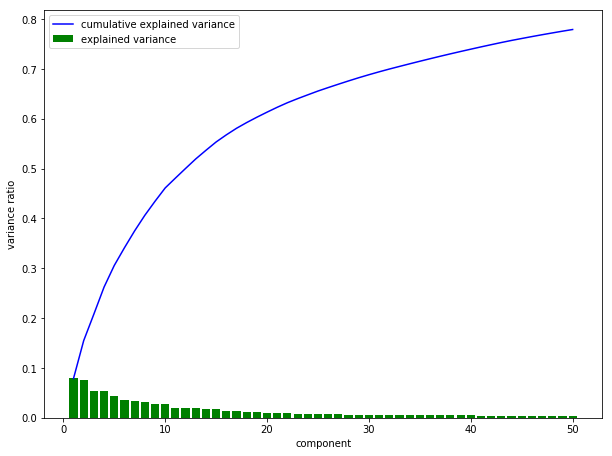

In [29]:
investigate_svd(t_svd)

### 1g. Bringing in Song Features

In [1]:
from library.song_feat_pull import *

In [2]:
get_song_feats('../data/song_features')

100 files completed
200 files completed
300 files completed
400 files completed
500 files completed
600 files completed
700 files completed
800 files completed
900 files completed
1000 files completed
1100 files completed
1200 files completed
1300 files completed
1400 files completed
1500 files completed
1600 files completed
1700 files completed
1800 files completed
1900 files completed
2000 files completed
2100 files completed
2200 files completed
2300 files completed
2400 files completed
2500 files completed
2600 files completed
2700 files completed
2800 files completed
2900 files completed
3000 files completed
3100 files completed
3200 files completed
3300 files completed
3400 files completed
3500 files completed
3600 files completed
3700 files completed
3800 files completed
3900 files completed
4000 files completed
4100 files completed
4200 files completed
4300 files completed
4400 files completed
4500 files completed
4600 files completed
4700 files completed
4800 files completed
4

In [2]:
rm_unnecessary_entries('/home/jovyan/Song_Index/data/interim/song_features/features_15052019.json')

### 1h. One-Hot Encoding Additional Features

In [36]:
def one_hot_encode_feats(ddf, column_names):
    '''
    Creates one-hot encoded features for specified columns in subset
    of dask dataframe
    '''
    if isinstance(ddf, pd.core.frame.DataFrame):
        ddf = dd.from_pandas(ddf)
    
    ddf = ddf.categorize(columns = column_names)
    de = DummyEncoder(columns = column_names)
    
    print('forcing categorical values')
    dummies = de.fit_transform(ddf[column_names])
    
    print('merging dummies back into other features')
    ddf = ddf.drop(column_names, 1)\
    .merge(dummies)
    
    return ddf

In [37]:
song_features_ddf = dd.read_csv('../data/interim/song_features/song_features_15052019.csv')\
                        .rename(columns = {'Unnamed: 0' : 'track_id'})

In [38]:
song_features_ddf.head()

,track_id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,3D5RGnxLPnXd80HWwdZUEL,0.0514,0.822,281797,0.567,0.000238,7,0.1280,-7.187,0,0.0376,151.991,3,0.690
1,4vUdO81Qm3aHE4Ue4qeLRA,0.1990,0.610,228800,0.687,0.000020,11,0.0785,-6.216,1,0.0388,123.044,4,0.399
2,2TdKU9OC5l2gCzpXi6N24k,0.0512,0.606,196800,0.808,0.000000,0,0.2320,-7.302,0,0.0896,169.807,4,0.741
3,7aw1PxKsmSMYYkb5EtXFEW,0.0036,0.845,239999,0.726,0.000000,1,0.2280,-8.840,0,0.1730,142.837,4,0.885
4,2MzaSLi8iFWQQ7fBE3rvDe,0.8340,0.124,121373,0.691,0.193000,9,0.9640,-7.610,0,0.0483,97.395,4,0.151


In [39]:
song_features_ddf = one_hot_encode_feats(song_features_ddf, ['key', 'time_signature'])

forcing categorical values
merging dummies back into other features


In [40]:
song_features_ddf.columns

Index(['track_id', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness',
       'tempo', 'valence', 'key_7', 'key_11', 'key_0', 'key_1', 'key_9',
       'key_5', 'key_2', 'key_6', 'key_4', 'key_8', 'key_10', 'key_3',
       'time_signature_3', 'time_signature_4', 'time_signature_5',
       'time_signature_1', 'time_signature_0'],
      dtype='object')

In [42]:
song_features_df = song_features_ddf.compute()

In [43]:
song_features_df.to_csv('../data/interim/song_features/song_features_encoded_20190515.csv')

In [44]:
type(song_features_df)

pandas.core.frame.DataFrame

### 1i. Combining Dataset 

In [33]:
segment_df = dd.read_csv('../data/segment_df_20190413.csv')

In [30]:
type(svdg)

numpy.ndarray

In [ ]:
def mk_songwriter_dataset(songwriter_df, genre_dummies, pitch_timbre_df, song_features):
    '''
    Creates dataframe of songs with features ready for modeling. First converting any
    pandas dataframes or numpy arrays into Dask objects
    '''

    
    

## 2. Creating "AVG" Songwriter Value for each Songwriter

In [7]:
!pip install update dask

In [8]:
# Do not use -- at least while running in a container.

# client = Client('scheduler:8786')

In [10]:
matched_w_writers = pd.read_csv('../data/matched_tracks_w_writers_20190422.csv', index_col = 0)

In [24]:
matched_w_writers = matched_w_writers.applymap(lambda x: np.NaN if x == '—' else x)

In [33]:
matched_w_writers.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 19 entries, Unnamed: 0 to PRO
dtypes: object(12), float64(3), int64(4)

In [28]:
matched_w_writers['IPI'] = matched_w_writers['IPI'].astype(pd.Int32Dtype())

In [30]:
matched_w_writers.to_csv('../data/matched_tracks_w_writers_20190504.csv')

In [9]:
# see imports on 1f.
# not even sure if I need anything outside of the `read_csv`
# from pandas.arrays import IntegerArray

# # The actual registration that would be done in the 3rd-party library
# from dask.dataframe.extensions import make_array_nonempty

# @make_array_nonempty.register(IntegerArray)
# def _(dtype):
#     return integer_array([0, None], dtype=dtype)

matched_w_writers = dd.read_csv('../data/matched_tracks_w_writers_20190504.csv',
                                dtype = {
                                    'track_id' : str,
                                    'Song Title' : str,
                                    'Artist' : str,
                                    'artist_id' : str,
                                    'name' : str,
                                    'popularity' : np.int8,
                                    'followers' : np.int32,
                                    'artist_name' : str,
                                    'song_id' : str,
                                    'song_title' : str,
                                    'CID' : np.int32,
                                    'PID' : np.int32,
                                    'Title': str,
                                    'Performer Name' : str,
                                    'WID' : np.int32,
                                    'Writer Name' : str,
                                    'IPI': pd.Int32Dtype(),
                                    'PRO' : 'category'
                                    })\
                      .rename(columns = {'Unnamed: 0' : 'index'})\
                      .set_index('index')

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/Song_Index/notebooks/../data/matched_tracks_w_writers_20190504.csv'

In [7]:
matched_w_writers.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 18 entries, track_id to PRO
dtypes: category(1), Int32(1), object(11), int32(4), int8(1)

In [15]:
matched_with_writers_numeric = matched_w_writers[['popularity', 'followers', 'CID', 'PID', 'WID']]

In [10]:
grouped_vals_avgs_ddf = matched_with_writers_numeric.groupby('WID').mean()

In [11]:
grouped_vals_avgs_ddf.head()

,popularity,followers,CID,PID
WID,,,,
1,63.555556,1.380916e+06,140022.111111,23343.222222
2,55.500000,4.530500e+05,23335.500000,240.500000
3,65.304762,8.502829e+05,73315.723810,14429.009524
4,67.264706,8.245521e+05,22609.264706,16.970588
5,67.621212,1.039455e+06,27845.575758,3303.651515


In [ ]:
def normalize_sngwriter(ddf):
    grouped_vals_ddf = ddf.groupby('WID').apply(lambda x: x / x.mean() )
    return grouped_vals_ddf

In [12]:
def normalize_by_avg_sngwrtr_value(ddf):
    
    grouped_vals_ddf = ddf.groupby('WID').mean()
    ddf_with_avgs = dd.concat([
        ddf,
        grouped_vals_ddf
    ])
    return ddf_with_avgs

In [16]:
new_ddf = create_avg_sngwrtr_value(matched_with_writers_numeric)

In [20]:
matched_with_writers_numeric.shape, new_ddf.shape

((Delayed('int-ecc518cf-14be-4a52-ac24-c49f15883eb9'), 5),
 (Delayed('int-be0da9dc-1032-40a6-8fb9-c43125904469'), 5))